In [1]:
import numpy as np
import gym
import math

from tqdm import tqdm
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from pprint import pprint

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3
class Observation:
    def __init__(self, state_hash, board, actions, cur_turn):
        self.hash = state_hash
        self.board = board
        self.actions = actions
        self.cur_turn = cur_turn
    
    def __repr__(self):
        return f'hash: {self.hash},\n board:\n {self.board},\n actions:{self.actions},\n turn:{self.cur_turn}'


class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        self.empty_spaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def get_empty_spaces(self):
        if self.empty_spaces is None:
            res = np.where(self.board == 0)
            self.empty_spaces = np.array([ self.int_from_action((i, j)) for i,j in zip(res[0], res[1])])
        return self.empty_spaces
        
    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.empty_spaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self) -> Observation:
        return Observation(self.getHash(), self.board, self.get_empty_spaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def _step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10 * self.curTurn, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}
    
    def step(self, num):
        state, reward, done, info = self._step(self.action_from_int(num))        
        return state, reward, done, info

    def reset(self)-> Observation:
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.empty_spaces = None
        self.curTurn = 1
        return self.getState()

In [3]:
class BaseAgent:
    def __init__(self, env: TicTacToe):
        self.env = env
        self.actions_count = env.n_rows * env.n_cols
    
    def learn(self, state, action, reward, new_state):
        pass
    
    def get_action(self, state: Observation, eps=0.01):
        pass

In [63]:
def plot_result(data, title): 
    plt.figure(figsize=(10,8))
    plt.plot(data[0], data[1], label='X')
    plt.plot(data[0], data[2], label='0')
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Mean reward')
    plt.title(title)
    plt.grid()
    plt.show()
    

## Часть первая: крестики-нолики при помощи Q-обучения

1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

Будем обучать двух агентов, которые на обучаются по отдельности против случайной стратегии, но иногда соревнуются друг с другом.

EPS-greedy Q-learning:

In [16]:
class QLearning(BaseAgent):
    def __init__(self, env, alpha=0.1, gamma=0.85):
        super().__init__(env)
        self.gamma = gamma
        self.alpha = alpha
        self.Q = {}
    
    def learn(self, state: Observation, action, reward, new_state: Observation):
        if state.hash not in self.Q:
            self.Q[state.hash] = np.random.random(size=self.actions_count)
        if new_state.hash not in self.Q:
            self.Q[new_state.hash] = np.zeros(shape=self.actions_count)
        Q = self.Q[state.hash][action]
        Qmax = np.max(self.Q[new_state.hash][state.actions])
        self.Q[state.hash][action] += self.alpha * (reward + self.gamma * Qmax - Q)
    
    def get_action(self, state: Observation, eps=0.0):
        if np.random.random() > eps:
            if state.hash not in self.Q:
                self.Q[state.hash] = np.zeros(shape=self.actions_count)
            return state.actions[np.argmax(self.Q[state.hash][state.actions])]
        return state.actions[np.random.randint(0, len(state.actions))]

In [17]:
class RandomAgent(BaseAgent):
    def get_action(self, state, eps=0):
        return state.actions[np.random.randint(0, len(state.actions))]

In [60]:
class TicTacToeSupervisor:
    def __init__(self, env: TicTacToe, agent1: BaseAgent, agent2: BaseAgent, agent3: BaseAgent):
        self.agent1 = agent1
        self.agent2 = agent2
        self.random_agent = agent3
        self.env = env
        self.eps = 0.1

    def run_episode(self, cross, nought, eps=0.1):
        done = False
        prevc_state = self.env.reset()
        cross_action = cross.get_action(prevc_state, eps)
        prevn_state, reward, done, _ = self.env.step(cross_action)
        while True:
            nought_action = nought.get_action(prevn_state, eps)
            curc_state, reward, done, _ = self.env.step(nought_action)
            cross.learn(prevc_state, cross_action, reward, curc_state)
            if done:
                nought.learn(prevn_state, nought_action, -reward, curc_state)
                break
            prevc_state = curc_state
            cross_action = cross.get_action(prevc_state, eps)
            curn_state, reward, done, _ = self.env.step(cross_action)
            nought.learn(prevn_state, nought_action, -reward, curn_state)
            if done:
                cross.learn(prevc_state, cross_action, reward, curn_state)
                break
            prevn_state = curn_state
    
    def evaluate(self, crosses: BaseAgent, noughts: BaseAgent, eps=0.0):
        done = False
        state = self.env.reset()
        while not done:
            state, reward, done, _ = self.env.step(crosses.get_action(state, eps))
            if done:
                break
            state, reward, done, _ = self.env.step(noughts.get_action(state, eps))
        
        return reward
    
    def fit(self, episodes, experiments, every, verbose=False):
        x = np.arange(0, episodes, every)
        scores = [np.zeros((episodes + every - 1) // every) for i in range(3)]
        measure_count = 0
        
        for i in tqdm(range(episodes)):
            self.run_episode(self.agent1, self.random_agent, self.eps)
            self.run_episode(self.random_agent, self.agent2, self.eps)

            if every > 0 and i % every == 0:
                for j in range(experiments):
                    scores[0][measure_count] += self.evaluate(self.agent1, self.random_agent)
                    scores[1][measure_count] -= self.evaluate(self.random_agent, self.agent2)
                for j in range(0, 2):
                    scores[j][measure_count] /= experiments
                if verbose:
                    print(f'Episode #{i} score:\t X:{scores[0][measure_count]}, | \tO:{scores[1][measure_count]}')
                measure_count += 1
        
        return (x, *scores)

In [61]:
env = TicTacToe()
superviser = TicTacToeSupervisor(env, QLearning(env, alpha=0.1, gamma=0.85), QLearning(env, alpha=0.1, gamma=0.85), RandomAgent(env))
data = superviser.fit(1000, 100, 300, True)

 29%|████████████████████████████                                                                      | 286/1000 [00:00<00:00, 1092.54it/s]

Episode #0 score:	 X:0.63, | 	O:-0.14


 66%|████████████████████████████████████████████████████████████████▉                                  | 656/1000 [00:00<00:00, 973.87it/s]

Episode #300 score:	 X:0.79, | 	O:0.26
Episode #600 score:	 X:0.83, | 	O:0.3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 995.03it/s]

Episode #900 score:	 X:0.88, | 	O:0.44


Обучим на доске 3х3

In [65]:
data

(array([     0,   2000,   4000,   6000,   8000,  10000,  12000,  14000,
         16000,  18000,  20000,  22000,  24000,  26000,  28000,  30000,
         32000,  34000,  36000,  38000,  40000,  42000,  44000,  46000,
         48000,  50000,  52000,  54000,  56000,  58000,  60000,  62000,
         64000,  66000,  68000,  70000,  72000,  74000,  76000,  78000,
         80000,  82000,  84000,  86000,  88000,  90000,  92000,  94000,
         96000,  98000, 100000, 102000, 104000, 106000, 108000, 110000,
        112000, 114000, 116000, 118000, 120000, 122000, 124000, 126000,
        128000, 130000, 132000, 134000, 136000, 138000, 140000, 142000,
        144000, 146000, 148000, 150000, 152000, 154000, 156000, 158000,
        160000, 162000, 164000, 166000, 168000, 170000, 172000, 174000,
        176000, 178000, 180000, 182000, 184000, 186000, 188000, 190000,
        192000, 194000, 196000, 198000]),
 array([0.45, 0.89, 0.98, 0.93, 0.93, 0.92, 0.96, 0.95, 0.88, 0.94, 0.97,
        0.95, 0.92, 

In [62]:
env = TicTacToe()
superviser = TicTacToeSupervisor(env, QLearning(env, alpha=0.1, gamma=0.85), QLearning(env, alpha=0.1, gamma=0.85), RandomAgent(env))
every=2000
data = superviser.fit(200000, 100, every, False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [02:18<00:00, 1447.61it/s]



Средний выигрыш за последние 20000 эпизодов у агента Х: 0.999
Средний выигрыш за последние 20000 эпизодов у агента 0: 0.867



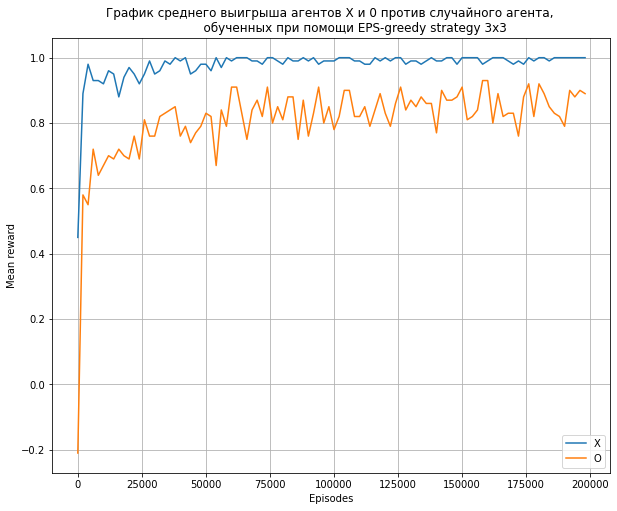

In [76]:
k = 10
print(f'''
Средний выигрыш за последние {every * k} эпизодов у агента Х: {data[1][-k:].sum() / k}
Средний выигрыш за последние {every * k} эпизодов у агента 0: {data[2][-k:].sum() / k}
''')
plot_result(data, 
            '''График среднего выигрыша агентов Х и 0 против случайного агента, 
            обученных при помощи EPS-greedy strategy 3x3'''
           )

2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.
Обучим для доски 4х4.

In [77]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
superviser = TicTacToeSupervisor(env, QLearning(env, alpha=0.2, gamma=1), QLearning(env, alpha=0.2, gamma=1), RandomAgent(env))
every = 10000
data = superviser.fit(500000, 50, every, False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [12:33<00:00, 663.55it/s]



Средний выигрыш за последние 200000 эпизодов у агента Х: 0.796
Средний выигрыш за последние 200000 эпизодов у агента 0: 0.5599999999999999



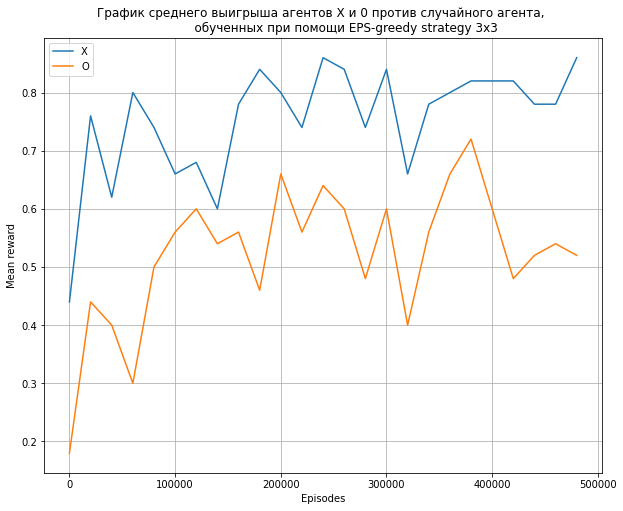

In [78]:
k = 10
print(f'''
Средний выигрыш за последние {every * k} эпизодов у агента Х: {data[1][-k:].sum() / k}
Средний выигрыш за последние {every * k} эпизодов у агента 0: {data[2][-k:].sum() / k}
''')
plot_result(data, 
            '''График среднего выигрыша агентов Х и 0 против случайного агента, 
            обученных при помощи EPS-greedy strategy 3x3'''
           )